In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
import functools
import pdb
%matplotlib inline

In [2]:
dataset=pd.read_csv('train.csv')

# preprocessing

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Imputer

In [4]:
dataset.shape

(1460, 81)

In [5]:
ids=dataset.loc[:,'Id']

In [6]:
dv=dataset.loc[:,'SalePrice']
lndv=np.log(dv)

In [7]:
def dist(x,bins):
    fig, ax1 = plt.subplots()
    ax1.set_ylabel('freq')
    ax1.hist(np.ravel(x),bins=bins,histtype='step')

    x.sort()

    ax2 = ax1.twinx()
    ax2.set_ylabel('prob')
    ax2.plot(np.ravel(x),st.norm.pdf(np.ravel(x),loc=np.mean(x),scale=np.std(x)),'--k')
    plt.show()

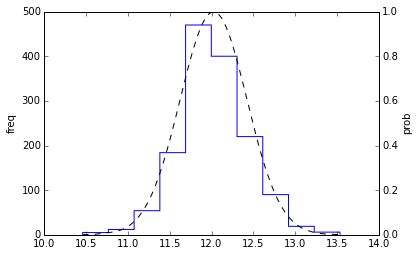

In [8]:
dist(lndv.tolist(),10)

In [9]:
dataset.drop('Id',1,inplace=True)

In [10]:
dataset.drop('SalePrice',1,inplace=True)

In [11]:
labenc2=LabelEncoder()
binfac=['Street','CentralAir']
dataset.loc[:,binfac]=dataset.loc[:,binfac].apply(lambda x: labenc2.fit_transform(x),axis=0).values

In [12]:
labenc6=LabelEncoder()
labenc6=labenc6.fit(['Ex','Gd','TA','Fa','Po','NA'])

In [13]:
qualityfac=['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC']
dataset.loc[:,qualityfac]=dataset.loc[:,qualityfac].fillna(value='NA').values
dataset.loc[:,qualityfac]=dataset.loc[:,qualityfac].apply(lambda x: labenc6.transform(x),axis=0).values

In [14]:
unordfac=['MSSubClass','MSZoning','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1',
          'Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
          'Heating','Electrical','GarageType','MiscFeature','MoSold','SaleType','SaleCondition','Fence']
otherfac=['Alley','BsmtExposure','BsmtFinType1','BsmtFinType2','Functional','GarageFinish','PavedDrive']
timefac=['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']
len(np.union1d(unordfac,otherfac)), dataset.loc[:,np.union1d(unordfac,otherfac)].apply(lambda x: len(pd.unique(x))).sum()

(33, 241)

In [15]:
dataset.loc[:,np.union1d(unordfac,otherfac)]=dataset.loc[:,np.union1d(unordfac,otherfac)].fillna(value='NA').values
dataset.loc[:,np.union1d(unordfac,otherfac)]=dataset.loc[:,np.union1d(unordfac,otherfac)].apply(lambda x: x.apply(str)).values

In [16]:
labenc=pd.Series([LabelEncoder() for i in np.union1d(unordfac,otherfac)],index=np.union1d(unordfac,otherfac))
for i in np.union1d(unordfac,otherfac):
    labels=pd.unique(dataset.loc[:,i]).tolist()
    if i=='MSSubClass': 
        labels.append('150')
    labels.append('NA')
    labenc[i]=labenc[i].fit(labels)

In [17]:
#for i in np.union1d(unordfac,otherfac):
#    pdb.set_trace()
#    labenc[i].transform(dataset.loc[:,i])

In [18]:
unordfacvars=pd.DataFrame([labenc[i].transform(dataset.loc[:,i]) for i in np.union1d(unordfac,otherfac)]).T
unordfacvars.columns=np.union1d(unordfac,otherfac)
dataset.loc[:,np.union1d(unordfac,otherfac)]=unordfacvars.values

In [19]:
#dummynames=[i+"_"+repr(j) for i in np.union1d(unordfac,otherfac) for j in pd.unique(unordfacvars.loc[:,i])]

In [20]:
#onehotenc=OneHotEncoder(categorical_features="all")
#onehotenc=onehotenc.fit(unordfacvars)

In [21]:
#unordfacvars=onehotenc.transform(unordfacvars)
#unordfacvars=pd.DataFrame(unordfacvars.todense(),columns=dummynames)
#unordfacvars.shape

In [22]:
#dataset=pd.concat([dataset,unordfacvars],axis=1)

In [23]:
#'Alley'

In [24]:
#'BsmtExposure'

In [25]:
#'BsmtFinType1','BsmtFinType2'

In [26]:
#'Functional'

In [27]:
#'GarageFinish'

In [28]:
#'PavedDrive'

In [29]:
facvars=functools.reduce(lambda x,y: np.union1d(x,y),[binfac,qualityfac,unordfac,otherfac])

In [30]:
#facvars=dataset.dtypes=='object'
#facvars=facvars[facvars].index.tolist()

In [31]:
#for i in facvars:
#    dataset.loc[:,i+'_fac']=pd.Series(dataset.loc[:,i].astype('category').cat.codes,index=dataset.index)

In [32]:
nulls=dataset.isnull().any()
nulls=np.setdiff1d(nulls[nulls].index,facvars)
sparse20=dataset.loc[:,nulls].apply(lambda x: sum(x.isnull())/dataset.shape[0]>0.2)
sparse20=sparse20[sparse20].index
nulls=np.setdiff1d(nulls,sparse20)
nulls.tolist()

['GarageYrBlt', 'LotFrontage', 'MasVnrArea']

In [33]:
imp=Imputer(missing_values='NaN',strategy='median',copy=False)
dataset.loc[:,nulls]=imp.fit_transform(dataset.loc[:,nulls])

In [34]:
#for i in nulls:
#    if i not in sparse20 and i not in catvars:
#        dataset.loc[dataset.loc[:,i].isnull(),i]=dataset.loc[:,nulls].median()[i]

In [35]:
dataset.loc[:,nulls].isnull().sum()

GarageYrBlt    0
LotFrontage    0
MasVnrArea     0
dtype: int64

In [36]:
#rmvars=functools.reduce(lambda x,y: np.union1d(x,y),[unordfac,otherfac,sparse20])
vars1=dataset.drop(sparse20,1)

In [37]:
set(vars1.dtypes), vars1.shape

({dtype('int64'), dtype('float64')}, (1460, 79))

In [40]:
vars1.loc[:,np.setdiff1d(vars1.columns,facvars)].describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1162.626712,346.992466,3.409589,2.866438,443.639726,46.549315,0.425342,0.057534,567.240411,21.954110,...,5.575342,6.099315,2.758904,15.060959,6.517808,1057.429452,94.244521,1971.267808,1984.865753,2007.815753
std,386.587738,436.528436,29.317331,0.815778,456.098091,161.319273,0.518911,0.238753,441.866955,61.119149,...,1.112799,1.382997,40.177307,55.757415,1.625393,438.705324,125.338794,30.202904,20.645407,1.328095
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000,2006.000000
25%,882.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,223.000000,0.000000,...,5.000000,5.000000,0.000000,0.000000,5.000000,795.750000,0.000000,1954.000000,1967.000000,2007.000000
50%,1087.000000,0.000000,0.000000,3.000000,383.500000,0.000000,0.000000,0.000000,477.500000,0.000000,...,5.000000,6.000000,0.000000,0.000000,6.000000,991.500000,0.000000,1973.000000,1994.000000,2008.000000
75%,1391.250000,728.000000,0.000000,3.000000,712.250000,0.000000,1.000000,0.000000,808.000000,0.000000,...,6.000000,7.000000,0.000000,0.000000,7.000000,1298.250000,168.000000,2000.000000,2004.000000,2009.000000
max,4692.000000,2065.000000,508.000000,8.000000,5644.000000,1474.000000,3.000000,2.000000,2336.000000,552.000000,...,9.000000,10.000000,738.000000,480.000000,14.000000,6110.000000,857.000000,2010.000000,2010.000000,2010.000000


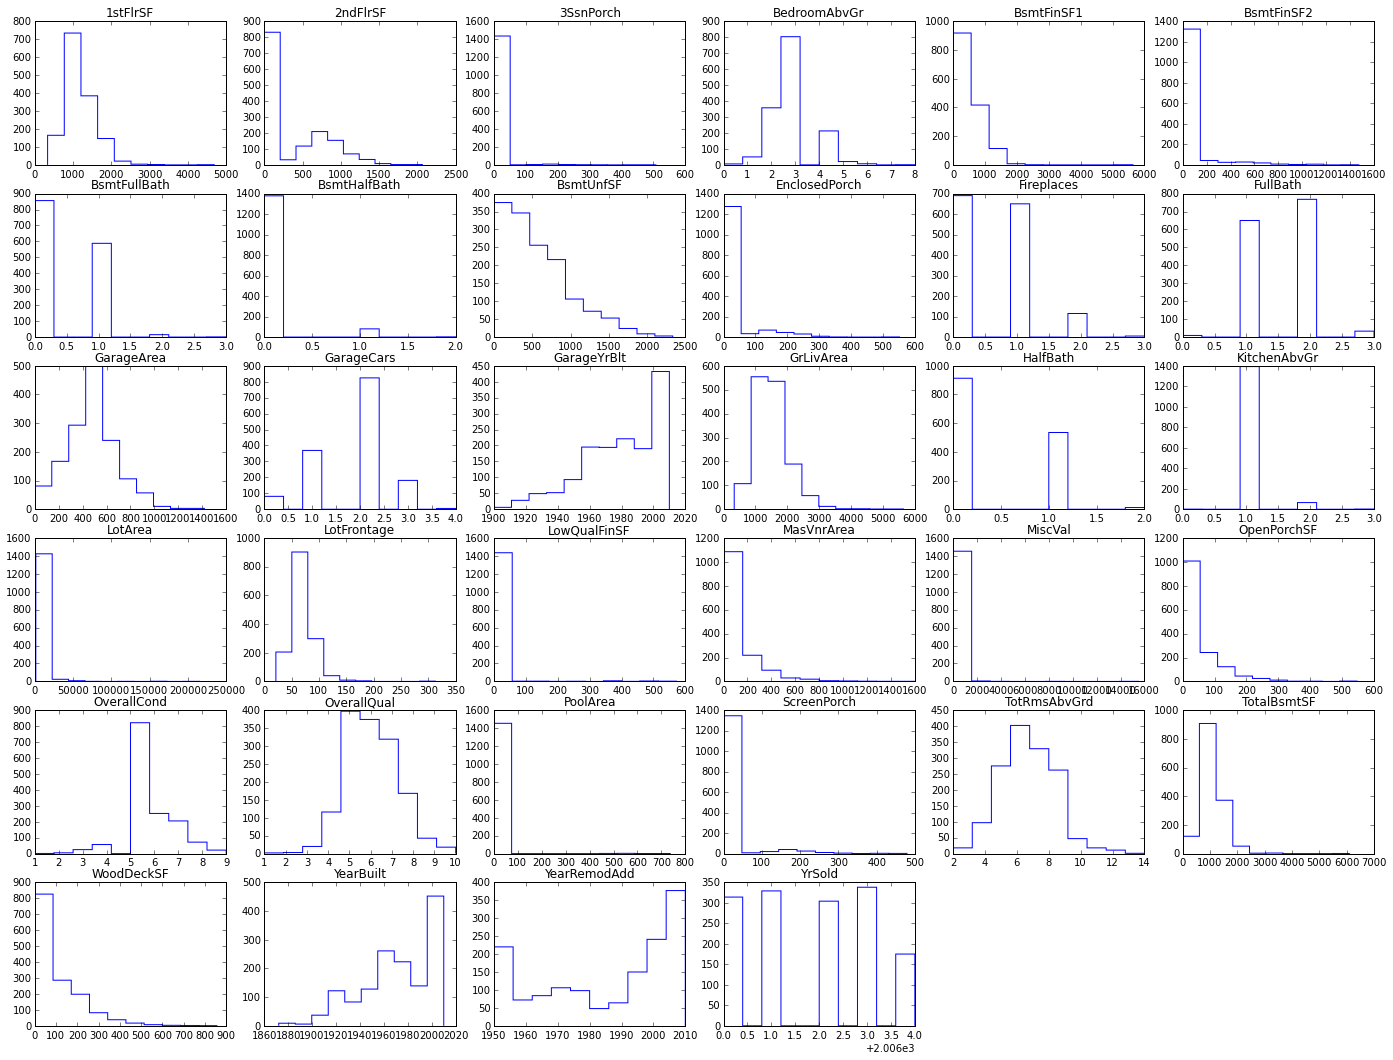

In [42]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 24
fig_size[1] = 18
j=1
for i in np.setdiff1d(vars1.columns,facvars):
    plt.subplot(6,6,j)
    plt.hist(vars1.loc[:,i].values,bins=10,histtype='step')
    #dist(vars1.loc[:,i].tolist(),10)
    plt.title(i)
    j+=1
plt.show()

In [ ]:
ratefac=['OverallCond','OverallQual']
countfac=['YrSold','TotRmsAbvGrd','KitchenAbvGr','HalfBath','GarageCars','FullBath','Fireplaces','BsmtHalfBath','BsmtFullBath',
             'BedroomAbvGr']

### remove NZV and linearize high variance

In [44]:
from sklearn.feature_selection import VarianceThreshold

In [51]:
varthresh=VarianceThreshold()
varthresh=varthresh.fit(vars1.loc[:,np.setdiff1d(vars1.columns,facvars)])
NZV=pd.Series(varthresh.variances_,index=np.setdiff1d(vars1.columns,facvars))
NZV.sort()
NZV

KitchenAbvGr            0.048516
BsmtHalfBath            0.056964
HalfBath                0.252720
BsmtFullBath            0.269084
FullBath                0.303300
Fireplaces              0.415310
GarageCars              0.558097
BedroomAbvGr            0.665038
OverallCond             1.237474
YrSold                  1.762629
OverallQual             1.911369
TotRmsAbvGrd            2.640094
YearRemodAdd          425.940882
LotFrontage           484.886216
GarageYrBlt           575.462620
3SsnPorch             858.917168
YearBuilt             911.590608
PoolArea             1613.110366
LowQualFinSF         2362.584730
ScreenPorch          3106.759983
EnclosedPorch        3732.991730
OpenPorchSF          4386.854449
WoodDeckSF          15699.053223
BsmtFinSF2          26006.083184
MasVnrArea          32641.456830
GarageArea          45681.200290
1stFlrSF           149347.716136
2ndFlrSF           190426.556793
TotalBsmtSF        192330.538174
BsmtUnfSF          195112.675764
BsmtFinSF1

# variable creation

# training

In [67]:
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV, ParameterGrid
from sklearn.metrics import r2_score

In [40]:
idev=train_test_split(var.index,test_size=0.3,random_state=1111)[0]

In [41]:
dev=var.iloc[idev,:]
val=var[~var.index.isin(idev)]
devdv=dv[idev]
valdv=dv[~var.index.isin(idev)]

### regularized linear model

In [70]:
from sklearn.linear_model import RidgeCV
model = RidgeCV(alphas=np.ravel([i for i in range(1000) if i>0]),scoring='mean_squared_error')

In [71]:
ridge=model.fit(dev,devdv)

In [74]:
ridge.score(val,valdv), ridge.alpha_

(0.83620700824887861, 15)

### random forest

In [96]:
from sklearn.ensemble import RandomForestRegressor

In [97]:
model2=RandomForestRegressor(random_state=9999)

In [102]:
from sklearn.grid_search import GridSearchCV

In [126]:
GS=GridSearchCV(model2,{'n_estimators':[150,200,250,300,350],'max_depth':[7,8,9,10],'min_samples_leaf':[10,20,30],'max_features':[0.5,0.7]},
               scoring='r2',n_jobs=4,cv=5,verbose=10000)

In [127]:
GS.fit(dev,devdv)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,)

[Parallel(n_jobs=4)]: Done  10 jobs       | elapsed:    6.0s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done  11 jobs       | elapsed:    6.3s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done  23 jobs       | elapsed:   12.0s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done  26 jobs       | elapsed:   12.5s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done  36 jobs       | elapsed:   16.1s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done  37 jobs       | elapsed:   16.1s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done  49 jobs       | elapsed:   21.1s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done  52 jobs       | elapsed:   21.5s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done  63 jobs       | elapsed:   24.3s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done  64 jobs       | elapsed:   24.7s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done  77 jobs       | elapsed:   29.7s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=

[Parallel(n_jobs=4)]: Done  89 jobs       | elapsed:   36.1s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done  90 jobs       | elapsed:   37.1s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 103 jobs       | elapsed:   44.8s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 100 jobs       | elapsed:   45.2s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 115 jobs       | elapsed:   50.9s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 116 jobs       | elapsed:   51.8s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 125 jobs       | elapsed:   57.5s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 129 jobs       | elapsed:   58.0s
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 141 jobs       | elapsed:  1.1min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 142 jobs       | elapsed:  1.1min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 154 jobs       | elapsed:  1.1min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 155 jobs       | elapsed:  1.2min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 167 jobs       | elapsed:  1.3min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 168 jobs       | elapsed:  1.3min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 180 jobs       | elapsed:  1.3min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 181 jobs       | elapsed:  1.4min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 193 jobs       | elapsed:  1.4min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 194 jobs       | elapsed:  1.4min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 206 jobs       | elapsed:  1.5min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 207 jobs       | elapsed:  1.5min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 219 jobs       | elapsed:  1.6min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 220 jobs       | elapsed:  1.6min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 232 jobs       | elapsed:  1.7min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 233 jobs       | elapsed:  1.7min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 245 jobs       | elapsed:  1.8min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 246 jobs       | elapsed:  1.9min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 258 jobs       | elapsed:  1.9min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 259 jobs       | elapsed:  2.0min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 271 jobs       | elapsed:  2.1min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 272 jobs       | elapsed:  2.1min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 285 jobs       | elapsed:  2.2min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 286 jobs       | elapsed:  2.2min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 298 jobs       | elapsed:  2.3min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 301 jobs       | elapsed:  2.3min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 311 jobs       | elapsed:  2.4min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 312 jobs       | elapsed:  2.4min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 324 jobs       | elapsed:  2.5min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 327 jobs       | elapsed:  2.5min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 338 jobs       | elapsed:  2.6min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 339 jobs       | elapsed:  2.6min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 352 jobs       | elapsed:  2.7min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 353 jobs       | elapsed:  2.7min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 364 jobs       | elapsed:  2.7min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 365 jobs       | elapsed:  2.7min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 377 jobs       | elapsed:  2.8min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 378 jobs       | elapsed:  2.8min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 390 jobs       | elapsed:  2.9min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 391 jobs       | elapsed:  3.0min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 404 jobs       | elapsed:  3.1min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 405 jobs       | elapsed:  3.1min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 417 jobs       | elapsed:  3.2min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 418 jobs       | elapsed:  3.2min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 430 jobs       | elapsed:  3.3min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 431 jobs       | elapsed:  3.3min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 443 jobs       | elapsed:  3.4min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 444 jobs       | elapsed:  3.4min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 456 jobs       | elapsed:  3.5min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 457 jobs       | elapsed:  3.5min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 469 jobs       | elapsed:  3.6min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 470 jobs       | elapsed:  3.6min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 482 jobs       | elapsed:  3.7min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 483 jobs       | elapsed:  3.7min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 495 jobs       | elapsed:  3.8min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 496 jobs       | elapsed:  3.8min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 508 jobs       | elapsed:  3.8min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 509 jobs       | elapsed:  3.9min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 521 jobs       | elapsed:  3.9min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 522 jobs       | elapsed:  3.9min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 535 jobs       | elapsed:  4.0min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 536 jobs       | elapsed:  4.1min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 551 jobs       | elapsed:  4.2min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 548 jobs       | elapsed:  4.2min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 561 jobs       | elapsed:  4.3min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 562 jobs       | elapsed:  4.3min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 576 jobs       | elapsed:  4.4min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(818,), dtype=int32).
Pickling array (shape=(204,), dtype=int32).
[Parallel(n_jobs=4)]: Done 574 jobs       | elapsed:  4.4min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

[Parallel(n_jobs=4)]: Done 587 jobs       | elapsed:  4.5min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(244,), dtype=int64).
Pickling array (shape=(43,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(817,), dtype=int32).
Pickling array (shape=(205,), dtype=int32).
[Parallel(n_jobs=4)]: Done 588 jobs       | elapsed:  4.5min
Pickling array (shape=(287,), dtype=object).
Pickling array (shape=(1022,), dtype=int64).
Pickling array (shape=(244, 1022), dtype=float64).
Pickling array (shape=(43, 1022), dtype=int64).
Pickling array (shape=(244,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling arr

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=9999,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=4,
       param_grid={'n_estimators': [150, 200, 250, 300, 350], 'min_samples_leaf': [10, 20, 30], 'max_depth': [7, 8, 9, 10], 'max_features': [0.5, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring='r2',
       verbose=10000)

In [128]:
GS.best_params_

{'max_depth': 9,
 'max_features': 0.5,
 'min_samples_leaf': 10,
 'n_estimators': 250}

In [129]:
GS.best_score_

0.83367967303591817

In [131]:
RF=RandomForestRegressor(max_depth=9,max_features=0.5,min_samples_leaf=10,n_estimators=250,random_state=9999)

In [132]:
RF=RF.fit(dev,devdv)

In [133]:
RF.score(val,valdv)

0.85406361064079639

# predictions

In [134]:
preds=RF.predict(var2)

In [135]:
submission=pd.DataFrame({'Id':ids,'SalePrice':preds})

In [136]:
submission.shape

(1459, 2)

In [137]:
submission.to_csv('submission3.csv',index=False)